<font color = 'red'> <b>Introduction</b></font>

Previously we trained a churn prediction model and we evaluated it. this week we take the model and deploy it on web service. since this model stays in the jupyter notebook

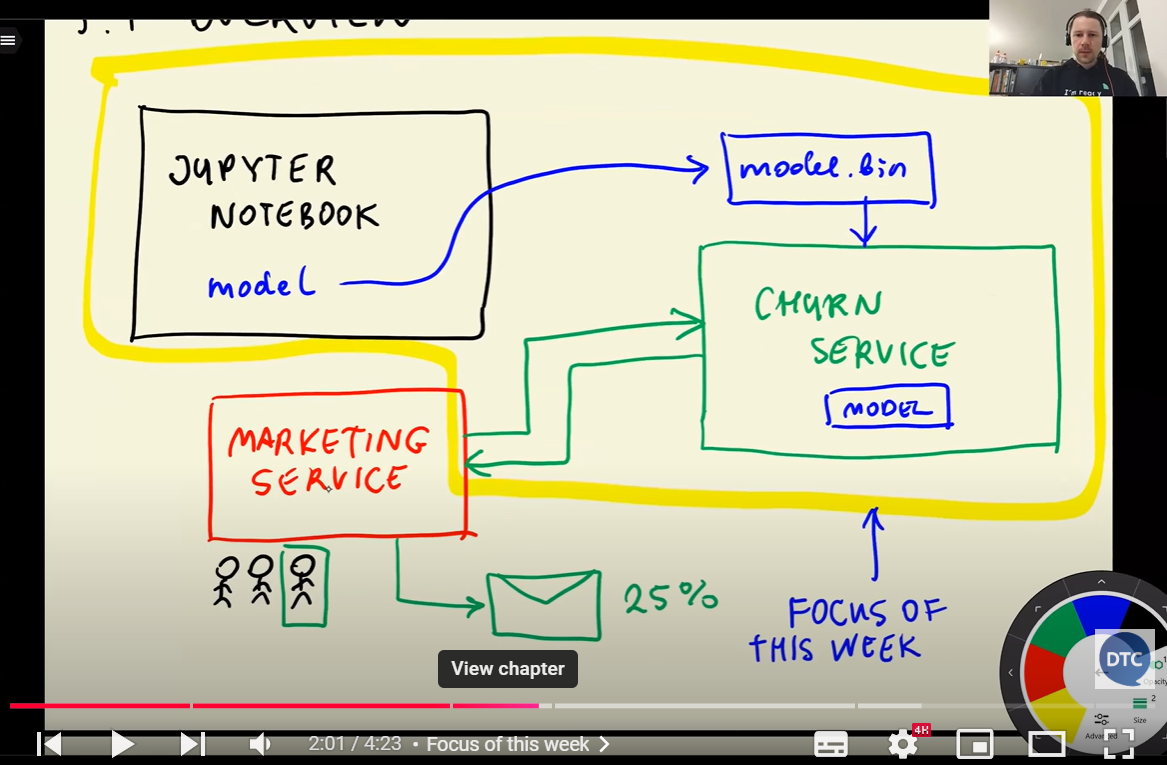

In [1]:
import pandas as pd 
import numpy as np 

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score



In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ','_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ','_')
    
    
df.totalcharges = pd.to_numeric(df.totalcharges, errors = 'coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn =='yes').astype(int)

In [3]:
df_full_train,df_test = train_test_split(df, test_size = 0.2,random_state=1)

In [4]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [5]:
def train(df_train,y_train,C=1.0):     # C is the regualrization parameter for the logistic regression just like there was one in the linear regression
    dicts = df_train[categorical+numerical].to_dict(orient='records')
    
    dv=DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C,max_iter=1000)
    model.fit(X_train,y_train)
    
    return dv,model

In [6]:
def Predict(df,dv,model):
    dicts = df[categorical+numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:,1]
    
    return y_pred

In [7]:
C=1.0
n_splits = 5

In [8]:
kfold = KFold(n_splits=n_splits, shuffle = True,random_state=1)

scores = []

for train_idx,val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.churn.values
    y_val = df_val.churn.values
    
    dv,model = train(df_train,y_train,C=C)
    y_pred = Predict(df_val,dv,model)
    
    auc = roc_auc_score(y_val,y_pred)
    scores.append(auc)
    
print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

C=1.0 0.842 +- 0.007


/home/codespace/.local/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [9]:
scores

[np.float64(0.8446632807655171),
 np.float64(0.8452295225797907),
 np.float64(0.833257074051776),
 np.float64(0.8346889588795804),
 np.float64(0.8517617897147877)]

In [10]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = Predict(df_test, dv, model)

y_test = df_test.churn.values
auc = roc_auc_score(y_test, y_pred)
auc

np.float64(0.8584005005037537)

Now the task will be to save our model and then put this inside web service for that we will use <font color = 'orange'>FLASK</font> that is a framework for creating web services in python.Then we want to isoltate the dependencies for this service in a way that this does not interfere with the other services that we have on out machine so we will create a special environment for python dependencies for this we will use <font color = 'orange'>PIPENV</font>. Then we will add another layer and this layer will be for system dependencies using <font color = 'orange'>DOCKER</font>. After all that we will deploy it on cloud. so we will take the container and deploy it on the <font color = 'orange'>AWS elastic beanstalk</font><br>
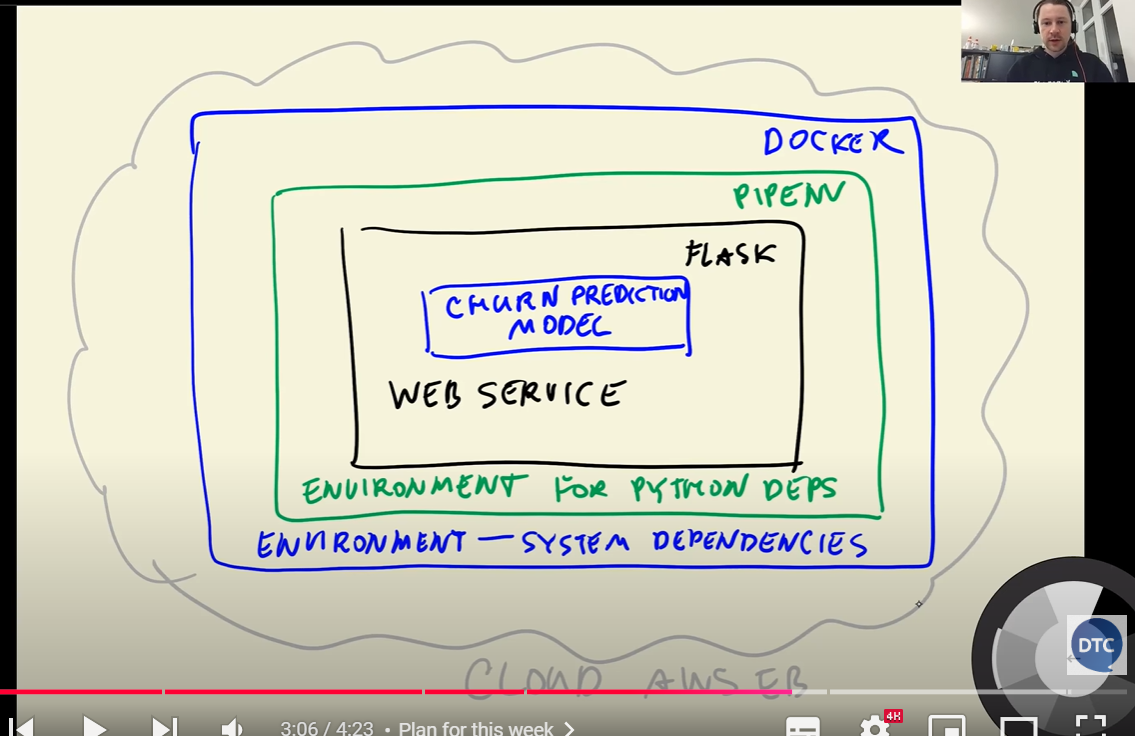

<b><font color ='red'><h4>Saving and loading the model</h4></font></b><br>

for saving the model we will use <font color = 'orange'>Pickle</font> that is a built in library for saving python objects

Save the model

In [11]:
import pickle

In [12]:
# Lets create a file where we will write the model.C
output_file = f'model_C={C}.bin' # this is how the name of our file will look like
output_file

'model_C=1.0.bin'

In [13]:
f_out = open(output_file,'wb') # Open opens the file and w refers to that we are going to write to the file and b refers to that bytes data will be written to that file
pickle.dump((dv,model),f_out) #we use dump function to write the file
f_out.close() # closing the file it is very important.


In [14]:
# sometimes we forget to close the file hence we can use the "with" that automatically closes the file

with open(output_file,'wb') as f_out:
    pickle.dump((dv,model),f_out)
    # do stuff 
    # till here as well the file is open
    
#do other stuff-- here the file is closed

<b>Load the model - restart the model and load the model. Restarting makes sure that this a different process now.</b>

In [15]:
import pickle

In [16]:
input_file = 'model_C=1.0.bin'
with open(input_file,'rb') as f_in:
    dv,model = pickle.load(f_in)


In [17]:
dv,model

(DictVectorizer(sparse=False), LogisticRegression(max_iter=1000))

As you can see that we did not imported scikit learn - but when we load the model using pickle then we need to have scikit learn in the model else it will show an error that I do not know what this is dict vectorizer and logisticregression


In [18]:
# now lets say we have a  new customer with the attribute values as following and we have to calcualte whether this customer will churn or not

customer = {
    'gender': 'female',
    'seniorcitizen': 0,
    'partner': 'yes',
    'dependents': 'no',
    'phoneservice': 'no',
    'multiplelines': 'no_phone_service',
    'internetservice': 'dsl',
    'onlinesecurity': 'no',
    'onlinebackup': 'yes',
    'deviceprotection': 'no',
    'techsupport': 'no',
    'streamingtv': 'no',
    'streamingmovies': 'no',
    'contract': 'month-to-month',
    'paperlessbilling': 'yes',
    'paymentmethod': 'electronic_check',
    'tenure': 1,
    'monthlycharges': 29.85,
    'totalcharges': 29.85
}



In [19]:
X = dv.transform([customer]) #dictionary vectorizer expect a list of dectionaries hence we created a list with just one dictonary


In [20]:
model.predict_proba(X)[0,1]

np.float64(0.6287358204858999)

Now this is not convinient to write these jupter notebook everytime and execute all this cells. so instead we want to have a single python file that just does that.

we created two pytohn file train.py and predict .py by breaking the above code only and did some command line execution. Till here we have not used flask hence the name of the files is simply train and predict.py once we have used the flask app then I will keep the name of the files as train_flask.py and predict_flask.py.<br>

For now we open the command prompt and navigate to the folder/directory where these files are saved and then run the following commands <b>python train.py</b>. this will train the model and using pickle will save the model in the same directory. then run <b>python predict.py</b> This already has the customer info as a dictionary and hence this will predict the value

<font color ='red'><h4><b>Web Services - Introduction to Flask</b></h4></font>

Writing a simple ping pong app that return pong if you send ping and then querying it using <font color = 'orange'><b>Curl</b></font>(used for communicating with web services) and Browser <br>
Web service is a method of communicatoin between two devices over a network<br>
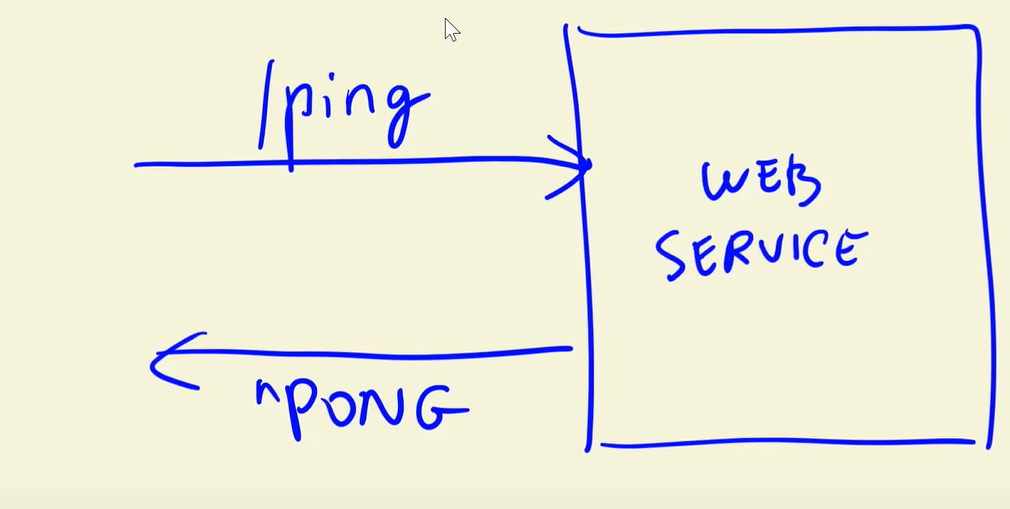


In [21]:
!pip install flask


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [ ]:
# i am writing the complete code here but this code has to be saved as a separate python file that is the .py file

from flask import Flask


app = Flask('Ping app')

@app.route('/ping',methods = ['GET'])     # to turn this function into web service. IN route we specify in which address this function will live. and methods is how exactly ar ewe going to access this route
def ping():
    return "PONG"



if __name__ == "__main__":   # this main method is run only when it is run as a script or as python -m
    app.run(debug=True,host = '0.0.0.0',port = 9696)  #0.0.0.0 is also known as the localhost, also this thing should live inside the main method that is the top level script environment.

<b>After saving it as a new file as ping.py. go to the command prompt and enter python ping.py it should start running the web service and then in a new terminal enter <font color = 'orange'> curl http://localhost:9696/ping</font>. In the command line you will get pong as output. The log of the requests is also maintained. that you can see in the command line terminal where the webservice is active.</b>

<font color ='red'><h4><b>Serving the Churn Model with Flask</b></h4></font>

In [23]:
#Lets pull in the code for predict.py and change that such that the flask can be used to convert it into  a web service.
import pickle

file_input = 'model_C=1.0.bin'

with open(file_input,'rb') as f_in:
    dv,model = pickle.load(f_in)

customer = {
    'gender': 'female',
    'seniorcitizen': 0,
    'partner': 'yes',
    'dependents': 'no',
    'phoneservice': 'no',
    'multiplelines': 'no_phone_service',
    'internetservice': 'dsl',
    'onlinesecurity': 'no',
    'onlinebackup': 'yes',
    'deviceprotection': 'no',
    'techsupport': 'no',
    'streamingtv': 'no',
    'streamingmovies': 'no',
    'contract': 'month-to-month',
    'paperlessbilling': 'yes',
    'paymentmethod': 'electronic_check',
    'tenure': 1,
    'monthlycharges': 29.85,
    'totalcharges': 29.85
}

X=dv.transform(customer)

y_pred = model.predict_proba(X)[0,1]

print("churn:",y_pred>0.5,"    churn probability:",y_pred)

churn: True     churn probability: 0.6287358204858999


In [ ]:
### now lets modify the above code such that we can create this as a webservice. ####

import pickle
import flask as Flask
from flask import request                   # since we will pass on the json file to the predict method and the output will also be json, and this contains requests to get the json and output json
from flask import jsonify                   # to convert a dictionary to json


model_input = 'model_C=1.0.bin'             # name of the model file

with open(model_input,'rb') as f_in:        #opening the file
    dv,model = pickle.load(f_in)            #Loading the dictionary vectorizer and model from the file

app = Flask('churn')                        #name of the app
@app.route('/predict',method = ['POST'])    #the reason that we are using POST not GET is because we want to send some information about the customer and we can not do that using the GET method. And this customer information will be sent in a json format and the resopose out will also be jason  
                                            #json looks exactly like dictionary it is just that instead of single quotes we use double quotes.
def Predict():                              # customer will come as an input into this web serive as json
    
    customer = request.get_json()           #it will take in the data from the request and assume that it is json and parse it as a python dictionary
    
    X=dv.transform(customer)
    y_pred = model.predict_proba(X)[0,1]
    
    #prepare json to output the file
    result = {
        "churn_probability": float(y_pred),             # the reason float is used since to convert it to python float instead of np.float that is the format of y_pred as that will throw error in json
        "churn" : bool(y_pred>0.5)                      #Similar reason that we are converting it to python bool 
        }
    
    
    return jsonify(result)



if __name__ == "__main__":   # this main method is run only when it is run as a script or as python -m
    app.run(debug=True,host = '0.0.0.0',port = 9696)  #0.0.0.0 is also known as the localhost, also this thing should live inside the main method that is the top level script environment.

In [24]:
# we will save the above code as predict_flask.py and then run it. Then we will communicate with this service from a jupyter notebook or another python script from a different terminal
# the reason for this is because the browser sends a get request if you type http://localhost:9696/predict and the output is that this methos is not allowed.
# And it is not easy to send a post request using browser. Hence we will use python and there is a great library called requests for that see the below code

In [ ]:
import requests


url = 'http://localhost:9696/predict'

# We will send this cusotmer in a post request
customer = {
    
    "gender": "female",
    "seniorcitizen": 0,
    "partner": "yes",
    "dependents": "no",
    "phoneservice": "no",
    "multiplelines": "no_phone_service",
    "internetservice": "dsl",
    "onlinesecurity": "no",
    "onlinebackup": "yes",
    "deviceprotection": "no",
    "techsupport": "no",
    "streamingtv": "no",
    "streamingmovies": "no",
    "contract": "month-to-month",
    "paperlessbilling": "yes",
    "paymentmethod": "electronic_check",
    "tenure": 1,
    "monthlycharges": 29.85,
    "totalcharges": 29.85
}

requests.post(url,json=customer) # we want to post a request on this Url and a json that is equal to this dictionary

 Once you run this service the resoponse will be 200 that meaning that it was successful. that you can see in the logs of the server<br>
 <br>
 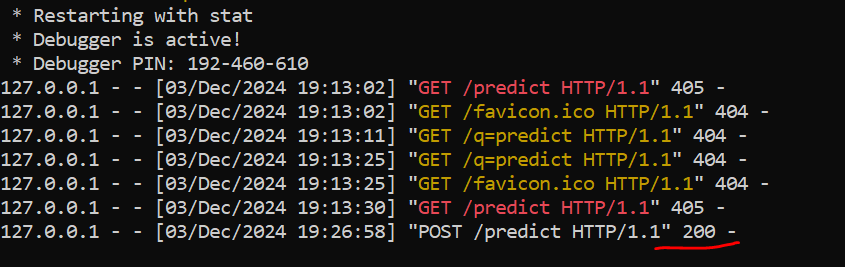

 to see the response from the serve modify the code as below so that we know the ouput is parsed as json<br>
<font color = 'orange'>requests.post(url,json=customer).json() </font>  if running through jupyter to see the results<br>

 and since we are running it from python script from command line hence we need to do it in this way to see the results in the command line<br>
<font color = 'orange'>print(requests.post(url,json=customer).json())</font> <br>
<br>
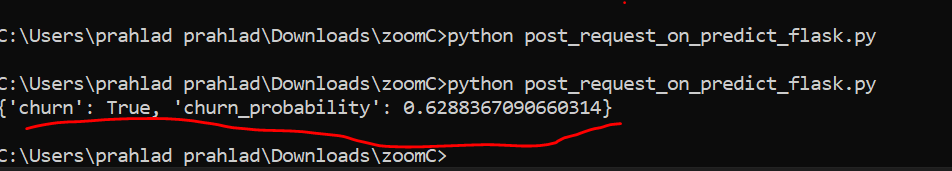

<b> Now when we run the predict_flask file we get a warining message that WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.<br>
Hence instead of using plain flask we have to use the WSGI server, there are many WSGI servers<br>
We ususally use <font color = 'orange'>Gunicorn</font> since that is designed for production

We install it and the way we use gunicorn is as <br>

<font color = 'orange'> gunicorn --bind 0.0.0.0:9696 predict:app </font> <br>

The reason that we use bind is because we need to bind the app to a port and previous code that is present in the script for binding in case of flask will not work, reason being that we are running it using gunicorn and hence the __name__==__main__ will be false 

however gunicorn will not work on plain windows so we can use <font color = 'orange'>Waitress</font><br>
use the following command to serve using waitress if the packages is not installed in path <br>
<font color = 'orange'>python -m waitress --listen=0.0.0.0:9696 predict_flask:app</font>

<font color = 'green'>In the next lessoon we will see dependency and environment management. If one project uses scikit learn 1.0 and other scikit learn 2.0 then they need to live together in one computer that we will see.</font>

<font color ='red'><h4><b> Python Virtual Environment: Pipenv</b></h4></font>


when you are doing an installation of a package that is pip install xyz then, pip looks for the default path in your environment variable and installs the latest version of the package since we did not explicitely menationed package version<br>

Lets say there is a scenario where we have two services that you different versions of the sckikit learn, in this case when we have two such services then we have to make sure that both of the services are able to run smoothly. But when we are installing a verison in our path varibale then both of them will refer to the same version of the package<br>

Hence we need a way to keep both the services separate in such a way that we can individually manage their dependencies.<br>

To solve this problem we use virtual environments and we put each serive in a different virtual environment and each of these environment has its own dependencies that do not interfere with each other<br>

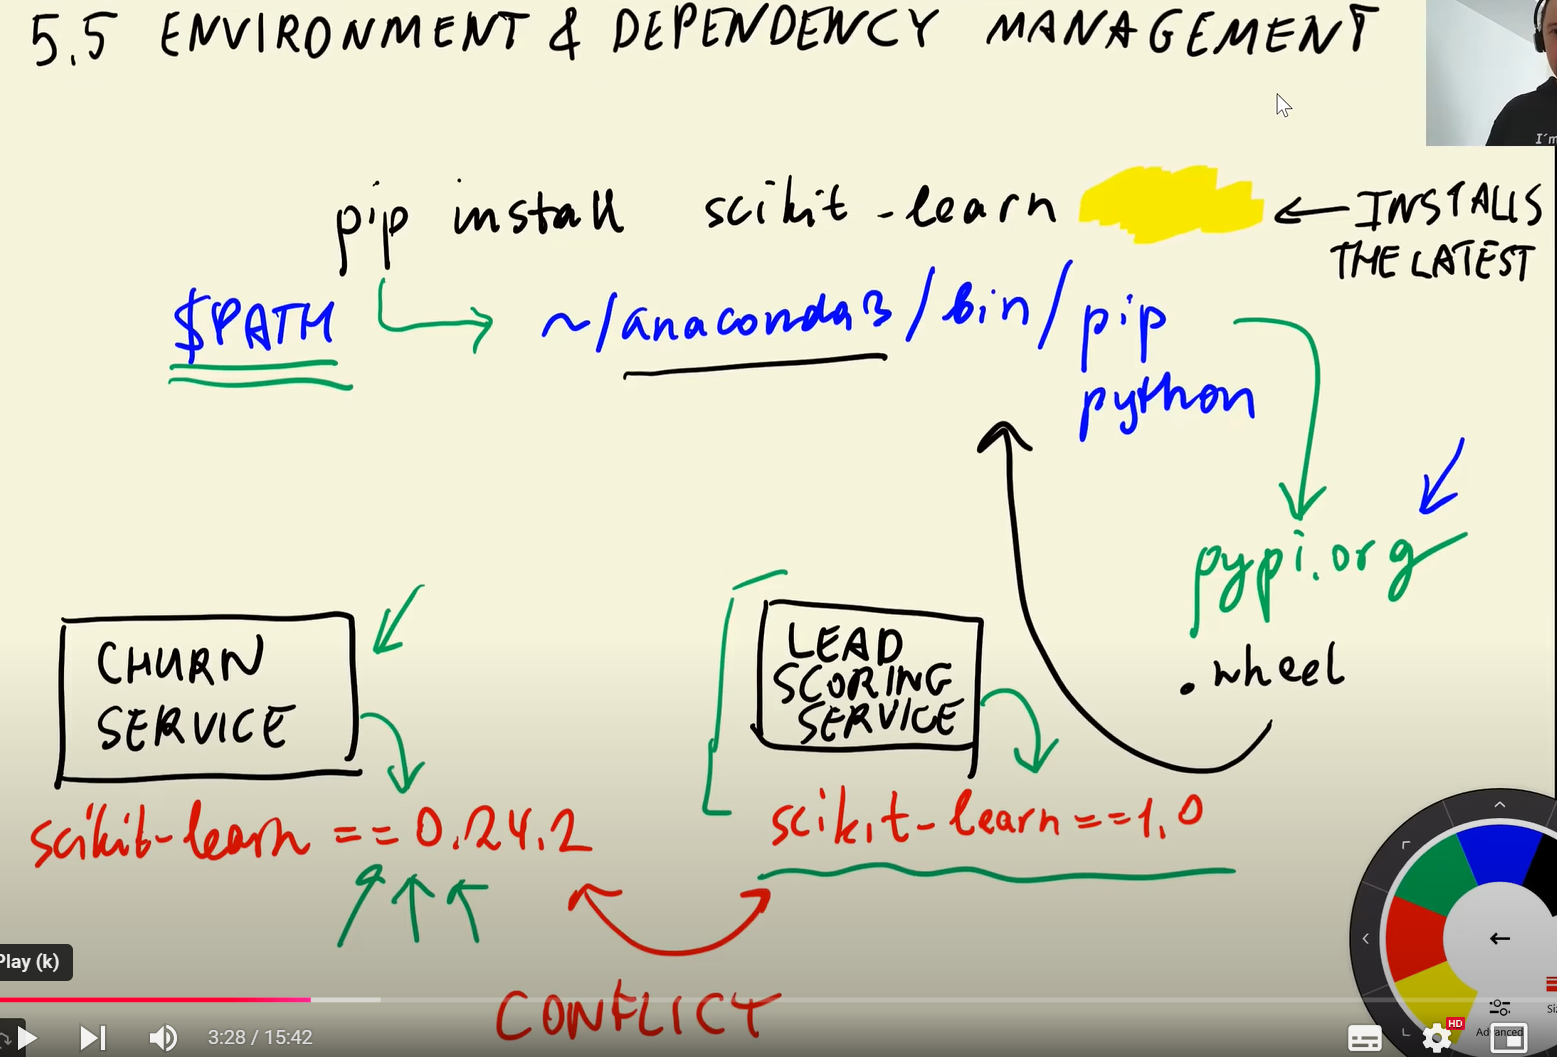

We have various packages to manage the virtual environments<br>
the most simple one is virtual env /venv  ---  this comes with the python <br>
Conda -- this is the one that anaconda uses<br>
pipenv -- the reason that we are using this one here since this is officially recommended by the python package community.<br>
poetry -- is more cool but works in exactly the same way as that of pipenv


In [ ]:
# run the following commands in the terminal of the vs code 
pip install pipenv

# after that to install any package to the virtual environment you just have to modify the above command as follows

pipenv install numpy scikit_learn == 0.24.2 flask

# if the above command does not work and throws the error that pipenv is not recognised command then in that case first open the virtual environment shell using this command

python -m pipenv shell 

# then install the librararies like this 
python -m pip install numpy scikit-learn==0.24.2 flask  # ther might be some issues due to this version since this might have been depricated in that case just type scikit-learn
# we should also add waitress

In [ ]:
# now once this is done that we have to get into that virtual environment so that when  we use python predict.py then we are sure that the dependacies of this python is used
